<a href="https://colab.research.google.com/github/IzmailovRuslan/super-duper-giggle/blob/main/Baseline_and_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Задача

Попробуем предсказать отток клиентов из банка

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны.


In [ ]:
from sklearn.metrics import roc_auc_score

# Первая часть. Исследование

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [ ]:
# У нас 20 признаков
len(data.columns)

20

In [ ]:
# Данные выглядят примерно так
data

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0
5278,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0
5279,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,0
5280,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0


In [ ]:
# Посмотрим, что скажет о данных pandas - как видим, пропусков нет.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

## Анализ данных

1) Для численных призанков - гистограммы (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). 

2) Для категориальных - количество каждого значения для каждого признака. Для каждой колонки можно сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* 

3) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

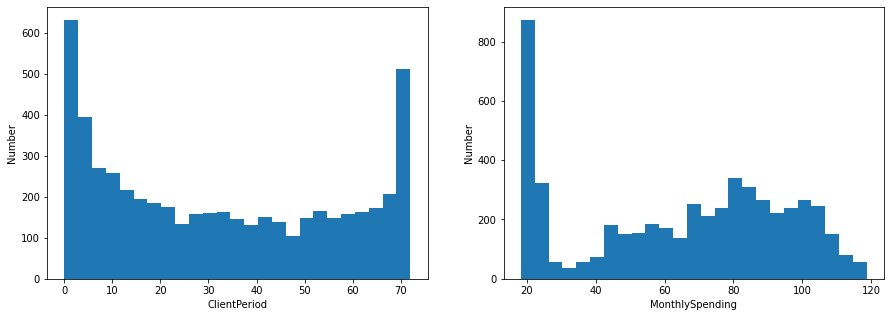

In [ ]:
# Посмотрим на численные признаки

fig, axes = plt.subplots(1, 2, figsize = (15,5))
axes[0].hist(data['ClientPeriod'], bins = 25)
axes[0].set_xlabel('ClientPeriod')
axes[0].set_ylabel('Number')

axes[1].hist(data['MonthlySpending'],  bins = 25)
axes[1].set_xlabel('MonthlySpending')
axes[1].set_ylabel('Number')
pass

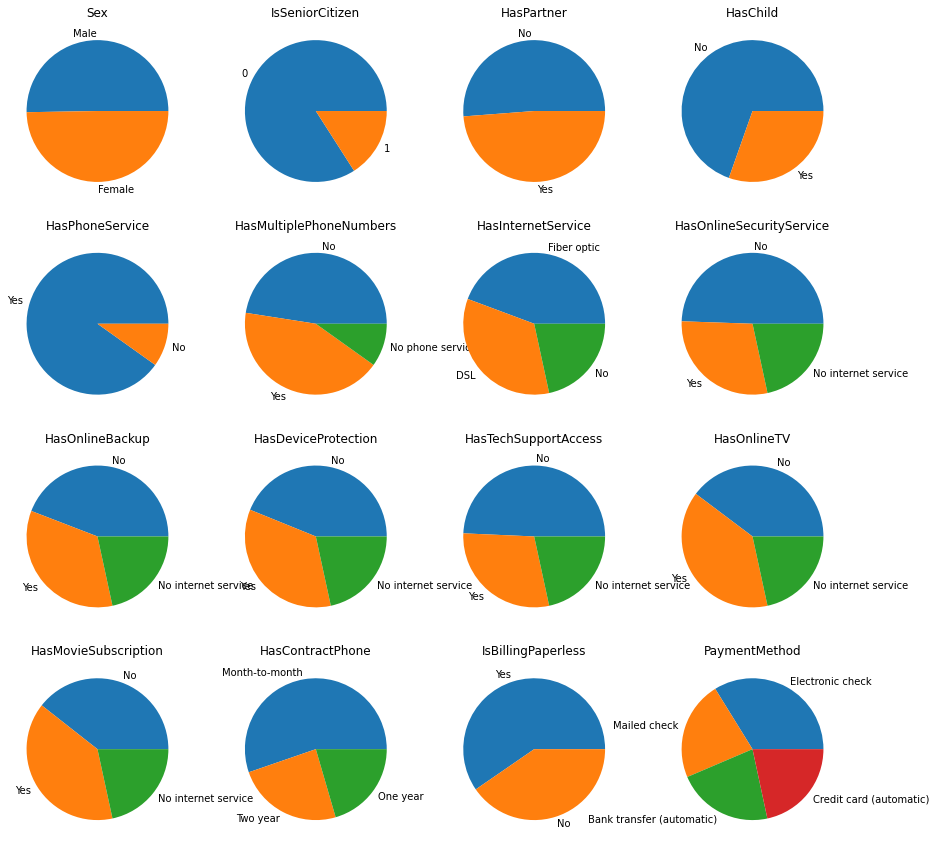

In [ ]:
# Посмотрим на категориальные признаки
fig, axes = plt.subplots(4, 4, figsize = (15,15))
for i in range(4):
  for j in range(4):
    axes[i, j].pie(data[cat_cols[4*i+j]].value_counts(), labels = data[cat_cols[4*i+j]].value_counts().index)
    axes[i, j].set_title(cat_cols[4*i+j])
pass

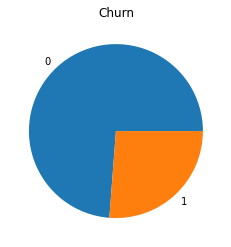

In [ ]:
# Целевой признак
# Отношение классов примерно 1:3 - классы сбалансированы
plt.pie(data['Churn'].value_counts(), labels = data["Churn"].value_counts().index)
plt.title('Churn')
pass

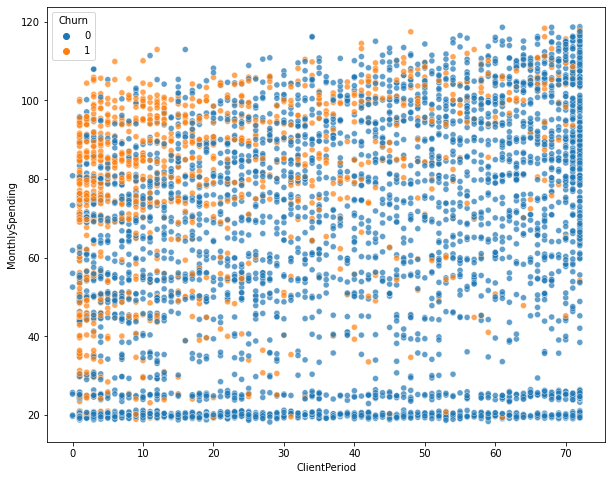

In [ ]:
# Визуализируем что-нибудь еще
import seaborn as sns   

plt.figure(figsize = (10, 8))
sns.scatterplot(x='ClientPeriod', y='MonthlySpending', hue='Churn', data=data, alpha=0.7)
pass

Как видно из данного графика, в основном отток состоит из тех, кто является клиентом банка не долгое время или тратит много денег

##Применение линейных моделей
1) Применить LogisticRegression. Перед этим - нормировка и one-hot-encoding.

2) С помощью кроссвалидации или разделения на train/valid выборку протестируем разные значения гиперпараметра C и выберем лучший по метрике ROC-AUC.

Преобразования данных и LogisticRegression соединяю в один Pipeline. Потом pipeline надо передаю в GridSearchCV.

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [ ]:
# Подготовим y
y = data['Churn']
data = data.drop('Churn', axis=1)

In [ ]:
# Категориальным признакам присвоим соответствующий тип
for c in cat_cols:
  data[c] = data[c].astype('category')

In [ ]:
# Бинаризация номинальных признаков
bin_cat = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'IsBillingPaperless',
    ]
    
for c in bin_cat:
  data[c] = data[c].cat.codes

In [ ]:
# One-hot encoding
not_bin_cat = [
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'PaymentMethod',
    ]
  
for c in not_bin_cat:
    data = pd.concat((data, pd.get_dummies(data[c], prefix=c, dtype='int8')), axis=1)
    data = data.drop([c], axis=1)

In [ ]:
# Теперь категориальных признаков нет!
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   ClientPeriod                                  5282 non-null   int64  
 1   MonthlySpending                               5282 non-null   float64
 2   TotalSpent                                    5282 non-null   object 
 3   Sex                                           5282 non-null   int8   
 4   IsSeniorCitizen                               5282 non-null   int8   
 5   HasPartner                                    5282 non-null   int8   
 6   HasChild                                      5282 non-null   int8   
 7   HasPhoneService                               5282 non-null   int8   
 8   IsBillingPaperless                            5282 non-null   int8   
 9   HasMultiplePhoneNumbers_No                    5282 non-null   i

In [ ]:
# Какая-то проблема с TotalSpent
# Оказывается, среди значений TotalSpent есть 9 примеров с пробелом 
filter = data['TotalSpent'].isin([' ']) 
data[filter]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,IsBillingPaperless,HasMultiplePhoneNumbers_No,...,HasMovieSubscription_No,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1048,0,25.75,,1,0,1,1,1,0,0,...,0,1,0,0,0,1,0,0,0,1
1707,0,73.35,,0,0,1,1,1,0,0,...,1,0,0,0,0,1,0,0,0,1
2543,0,19.70,,1,0,1,1,1,1,1,...,0,1,0,0,1,0,0,0,0,1
3078,0,80.85,,0,0,1,1,1,0,1,...,0,0,1,0,0,1,0,0,0,1
3697,0,20.00,,0,0,1,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
4002,0,61.90,,1,0,0,1,1,1,0,...,1,0,0,0,0,1,1,0,0,0
4326,0,25.35,,1,0,1,1,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4551,0,52.55,,0,0,1,1,0,1,0,...,1,0,0,0,0,1,1,0,0,0
4598,0,56.05,,0,0,1,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0


In [ ]:
# Заменяем пробелы на NaN
data = data.replace(" ", np.nan)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# Создадим pipeline

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [ ]:
pipe = Pipeline([('SimpleImputer', imputer), ('scaler', StandardScaler()), 
                 ('model', LogisticRegression())])

In [ ]:
grid = GridSearchCV(pipe, 
                    {
                    'model__C': [100, 10, 5, 3, 1, 0.5, 0.1, 0.01, 0.001],
                    }, 
                    cv=StratifiedKFold(5, shuffle=True, random_state=42),
                    scoring = 'roc_auc'
                    )

In [ ]:
grid.fit(data, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('SimpleImputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [100, 10, 5, 3, 1, 0.5, 0.1, 0.01, 0.001]},
             scoring='roc_auc')

In [ ]:
grid.best_params_

{'model__C': 5}

In [ ]:
grid.cv_results_

{'mean_fit_time': array([0.11555037, 0.11240706, 0.11761065, 0.11665425, 0.11092534,
        0.11101542, 0.10379725, 0.08863602, 0.07558589]),
 'mean_score_time': array([0.01201606, 0.01202173, 0.01262512, 0.01249261, 0.01250052,
        0.01218839, 0.01245337, 0.01227851, 0.01204906]),
 'mean_test_score': array([0.84479809, 0.84484445, 0.84487689, 0.84486026, 0.84484005,
        0.84470399, 0.84406615, 0.84215385, 0.83788506]),
 'param_model__C': masked_array(data=[100, 10, 5, 3, 1, 0.5, 0.1, 0.01, 0.001],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'model__C': 100},
  {'model__C': 10},
  {'model__C': 5},
  {'model__C': 3},
  {'model__C': 1},
  {'model__C': 0.5},
  {'model__C': 0.1},
  {'model__C': 0.01},
  {'model__C': 0.001}],
 'rank_test_score': array([5, 3, 1, 2, 4, 6, 7, 8, 9], dtype=int32),
 'split0_test_score': array([0.84198139, 0.84196751, 0.84193511, 0

Получили значение метрики AUC-ROC равное  0.84487689 при значении параметра С = 5


In [ ]:
# Сделаем предсказание для файла test.csv
valid =pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [ ]:
# Категориальным признакам присвоим соответствующий тип
for c in cat_cols:
  valid[c] = valid[c].astype('category')

# Бинаризация номинальных признаков
bin_cat = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'IsBillingPaperless',
    ]
    
for c in bin_cat:
  valid[c] = valid[c].cat.codes

# One-hot encoding
not_bin_cat = [
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'PaymentMethod',
    ]
  
for c in not_bin_cat:
    valid = pd.concat((valid, pd.get_dummies(valid[c], prefix=c, dtype='int8')), axis=1)
    valid = valid.drop([c], axis=1)

In [ ]:
# Заменяем пробелы на NaN
valid = valid.replace(" ", np.nan)

In [ ]:
submission['Churn'] = grid.best_estimator_.predict_proba(valid)[:, 1]

In [ ]:
submission.to_csv('my_submission1.csv', index=False)

На kaggle это решение имеет оценку Score: 0.84574

Ссылка на соревнование: https://www.kaggle.com/competitions/advanced-dls-spring-2021

## Применение градиентного бустинга 

Часто градиентный бустинг с дефолтными параметрами даёт 80% результата за 0% усилий.

Используем catboost, поэтому не надо кодировать категориальные признаки - catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Протестируем catboost cо стандартными параметрами.

2) Протестируем разные значения параметра количества деревьев и learning_rate'а 

In [ ]:
pip install catboost

     |████████████████████████████████| 76.1 MB 65 kB/s 


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Churn', axis=1), data['Churn'], test_size=0.2)

In [ ]:
boost = CatBoostClassifier(iterations = 100,   #количество повторений
                           eval_metric = 'AUC',   #метрика
                           ) 

In [ ]:
# Обучимся со стандартными параметрами
boost.fit(X_train, y_train, eval_set=[(X_test, y_test)], use_best_model=True, cat_features=cat_cols)

In [ ]:
boost = CatBoostClassifier(iterations=100,   #количество повторений
                           eval_metric = 'AUC',   #метрика
                           loss_function='Logloss',  #функция потерь
                          ) 
grid = GridSearchCV(boost, 
                    {
                    'depth': [3, 4, 5, 6],
                    'learning_rate': [0.01, 0.05, 0.1, 0.15]
                    }, 
                    cv=StratifiedKFold(5, shuffle=True, random_state=42))

In [ ]:
grid.fit(X_train, y_train, eval_set=[(X_test, y_test)], cat_features=cat_cols)

In [ ]:
grid.best_params_

{'depth': 3, 'learning_rate': 0.05}

# Предсказания

In [ ]:
best_model = grid.best_estimator_

In [ ]:
valid =pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

submission['Churn'] = best_model.predict_proba(valid)[:, 1]

submission.to_csv('my_submission2.csv', index=False)

Это решение оценено на kaggle Score: 0.85129

Ник на kaggle: irusl_1337, team: Ruslan Izmailov
